In [45]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
import numpy as np
from IPython.display import Image
# So we can see the output of multiple variables in a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# data I/O
# input.txt should be simple plain text file with letters/chars
data = open('input.txt', 'r').read() 
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data_size %d characters, and vocab_size %d (unique).' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias
pass;

data_size 5 characters, and vocab_size 5 (unique).


Wxh.shape (100, 5)
Whh.shape (100, 100)
Why.shape (5, 100)
bh.shape (100, 1)
by.shape (5, 1)


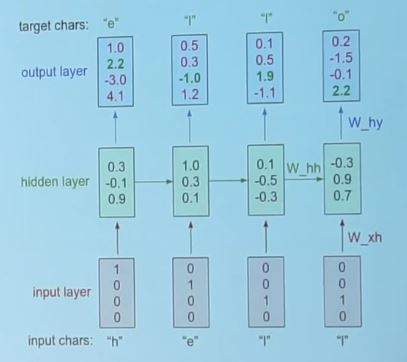

In [22]:
print('Wxh.shape', Wxh.shape)
print('Whh.shape', Whh.shape)
print('Why.shape', Why.shape)
print('bh.shape',bh.shape)
print('by.shape',by.shape)
Image('img/flow-chart-1.JPG', width=300)

In [76]:
inputs; targets; hprev.shape;
hs_copy = np.copy(hprev)

[1, 3, 2, 0, 4]

[3, 2, 0, 4]

(100, 1)

In [58]:
xs = np.zeros((vocab_size,1));xs
xs[inputs[0]]=1; xs
xs[inputs[1]]=1; xs

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

array([[ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.]])

array([[ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.]])

In [3]:
def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs = {} # is the one hot encoded matrix that makes up our chars array 5x5
    hs = {} # hidden state matrix. `
    ys = {} # holds logtis output in array 100x1
    ps = {} # holds softmax probs in array 100x1
    hs[-1] = np.copy(hprev) # get a copy of 
    loss = 0
    
    ''' FORWARD PASS -- compute loss '''
    for t in range(len(inputs)):
        
        # encode in 1-of-k representation
        xs[t] = np.zeros((vocab_size,1))
        xs[t][inputs[t]] = 1
        
        # hidden state.
        #                  (100x100 * 100x1) + (100x5 * 5x1)      + (100x1) = 
        hs[t] = np.tanh(np.dot(Whh, hs[t-1]) + np.dot(Wxh, xs[t]) + bh)
        # Logits
        ys[t] = np.dot(Why, hs[t]) + by
        # probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) 
        # softmax (cross-entropy loss)
        loss += -np.log(ps[t][targets[t], 0]) 
        
    ''' BACKWARD PASS -- compute param gradient '''
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dy[targets[t]] -= 1 
        dWhy += np.dot(dy, hs[t].T)
        dby 
        += dy
        # backprop into h
        dh = np.dot(Why.T, dy) + dhnext
        # backprop through tanh nonlinearity
        dhraw = (1 - hs[t] * hs[t]) * dh
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
        
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        # clip to mitigate exploding gradients
        np.clip(dparam, -5, 5, out=dparam) 
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

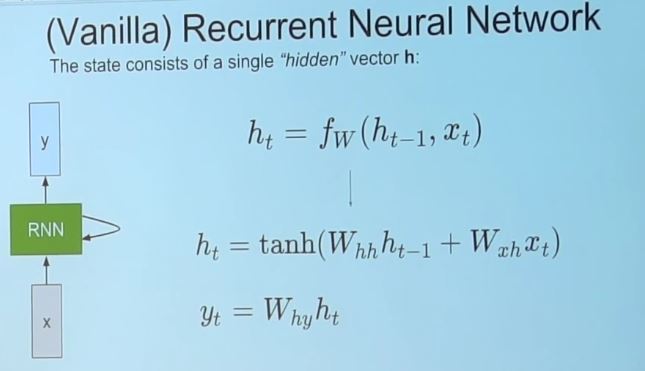

In [60]:
Image('img/hidden-vector.JPG', width=300)

In [4]:
def sample(h, seed_ix, n):
    """
    sample a sequence of integers from the model
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

### Main Loop

In [78]:
# initializations
n = 0 # iteration counter
p = 0 # data pointer
# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) 
# loss at iteration 0
smooth_loss = -np.log(1.0/vocab_size)*seq_length # about 40

while True:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0:
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p    : p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1 : p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt, ))

    '''
    forward seq_length characters through the net and fetch gradient
    hprev is the hidden state vector. So we're going in batches of 25 and we are
    keeping track of the hidden state vector at the end of your 25 letters so when 
    we feed the next batch, we can feed this hidden vector hprev as the initial H at
    that time step -- we're only doing backprop those 25 time steps.
    '''
    print('hprev', hprev)
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 100 == 0: print('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                  [dWxh, dWhh, dWhy, dbh, dby],
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter
pass;

----
 olhoelooe
lo
ehhl
oohlhhl
hhhoh
ohh
ohee
ollho
oheo
oho
loloo
hohooh
o
lll

looelollehlolheee
e

eoh
e
eehehlell
o
heo
eeehhlhheel

eh
hle
oohhehehe
eeeeohloohheeleoeoelooeelo
lhllll
eh
leeh
hheo
loeo 
----
hprev [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


IndexError: list index out of range

In [38]:
inputs
targets

[1, 3, 2, 0, 4]

[3, 2, 0, 4]